# Atomistic simulation of materials

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## A box of particles: setting up the simulation supercell
### The box
First, a box is set up to hold the simulation where in this case, the box is made just the right size to hold the block of crystal required.

In [4]:
L = 4 # length of cube sides in unit cells
boxsize = np.array([L,L,L]) # defining a cubic box in multiples of the unit cell size in each direction

Since bcc iron is to be simulated too, it is needed to specify the lattice parameter too, where the lattice vectors along the edges of the unit cell and the motif for bcc:

In [6]:
alatt = 2.86 # lattice parameter
cell = np.array([
        [alatt,0,0],
        [0,alatt,0],
        [0,0,alatt]
    ]) # specifying vectors in rows of an array
motif = np.array([
        [0.0,0.0,0.0],
        [0.5,0.5,0.5] # postions of atoms in motif in multiples of lattice vectors
    ])
nmotif = len(motif) # number of atoms in motif

### Filling the box with particles
In an irradiation damage simulation, the particles will represent atoms, which are treated as point-particles. The state of a set of point particles is completely specified as long as the position and the momentum (or, equivalently, the velocity and mass) of every particle is known.

In [10]:
def createcrystal(cell,motif,nmotif,boxsize):
    rlist = []
    for i in range(boxsize[0]): # iterating over unit cells in x-direction
        for j in range(boxsize[1]): # iterating over unit cells in y-direction
            for k in range(boxsize[2]): # iterating over unit cells in z-direction
                for l in range(nmotif): # iterating over atoms in motif
                    # working out atom coordinates
                    thisr = i*cell[0,:] + j*cell[1,:] + k*cell[2,:] + motif[l,:]
                    # adding coordinates to list
                    rlist.append([thisr[0],thisr[1],thisr[2]])
    r = np.array(rlist) # creating an array from contents of list
    return r

In [ ]:
# creating an array of the coordinates of the particles

In [12]:
r = createcrystal(cell,motif,nmotif,boxsize)

### Visualising the atomic configuration

In [ ]:
# producing 3d plot to visualise coordinates

In [14]:
def plotcell(r, cell, boxsize):
    fig = plt.figure(figsize=(15, 6))
    # plotting a 3d view of the crystal
    ax = fig.add_subplot(1,4,1, projection='3d')
    ax.scatter(r[:,0], r[:,1], r[:,2])
    #ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    labels = ['x','y','z']
    # plotting 3 views of the crystal in different directions
    maxdim = 0.0
    for s in range(3): # checking for the largest dimension of the box
        if cell[s,s]*boxsize[s] > maxdim:
            maxdim = cell[s,s]*boxsize[s]        
    for s in range(3): # loop runs over the 3 different views of the crystal
        # defining an array, cellbox, of five points at the four corners of the cell, plus the first corner again
        cellbox = np.array([
            [0.0,0.0],
            [0.0,cell[(s+1)%3,(s+1)%3]*boxsize[(s+1)%3]],
            [cell[s,s]*boxsize[s],cell[(s+1)%3,(s+1)%3]*boxsize[(s+1)%3]],
            [cell[s,s]*boxsize[s],0.0],
            [0.0,0.0]
        ])
        ax = fig.add_subplot(1,4,2+s, aspect='equal')
        ax.plot(r[:,s], r[:,(s+1)%3],'bo')  # plotting the atoms
        ax.plot(cellbox[:,0],cellbox[:,1], 'k-')  # plotting the box
        ax.set_xlim(-0.1*maxdim,1.1*maxdim)
        ax.set_ylim(-0.1*maxdim,1.1*maxdim)
        ax.set_xlabel(labels[s])
        ax.set_ylabel(labels[(s+1)%3])


In [ ]:
# visualising simulation cell

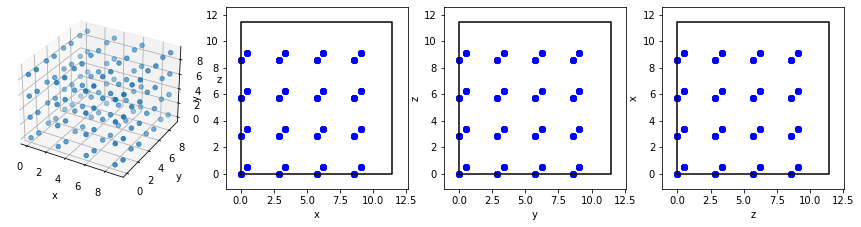

In [7]:
plotcell(r, cell, boxsize)

### Correcting the `createcrystal()` function

In [16]:
def createcrystal(cell,motif,nmotif,boxsize):
    rlist = []
    for i in range(boxsize[0]): # iterating over unit cells in x-direction
        for j in range(boxsize[1]): # iterating over unit cells in y-direction
            for k in range(boxsize[2]): # iterating over unit cells in z-direction
                for l in range(nmotif): # iterating over atoms in motif
                    # working out atom coordinates
                    thisr = (i+motif[l,0])*cell[0,:] + (j+motif[l,1])*cell[1,:] + (k+motif[l,2])*cell[2,:]
                    # adding coordinates to list
                    rlist.append([thisr[0],thisr[1],thisr[2]])
    r = np.array(rlist) # creating an array from contents of list
    return r

#### Create a new simulation cell and visualise it
Use the corrected `createcrystal()` function to create a new simulation cell and check that it now looks okay.

In [18]:
r = createcrystal(cell,motif,nmotif,boxsize)
plotcell(r,cell,boxsize)

### The other properties of the particles
In a classical system of particles, the state of the system is fully specified if the position and momentum of every particle is known. An array of positions has been obtained, but the velocities of the particles should now be specified.

In [ ]:
# setting velocities to zero by creating an array of the correct size filled with zeros

In [20]:
natoms = len(r) # total number of atoms
v = np.zeros((natoms,3)) # creating an array of velocities (all zero)
a = np.zeros((natoms,3)) # creating an array of accelerations (all zero)

In [ ]:
# creating an array of the correct size filled with the appropriate value

In [22]:
mass = 55.8
m = np.full(natoms,mass)

## Specifying the interaction between particles

An array of iron atoms has been placed in a box, but at this stage, the only thing that defines them as iron, rather than another material, is that they are arranged in a body-centered cubic structure with a lattice parameter corresponding to that of iron and have the correct atomic mass. However, to run a dynamical simulation, the atoms need to respond to *forces* acting between them. In reality, these forces are determined by the behavior of electrons in the material, responding to electrostatic forces according to the laws of quantum mechanics. Since this simulation will use classical physics, a *model* for these interatomic forces is required. These model forces are known as interatomic potentials or *empirical potentials*. Various types of potentials are available for different tasks, but in this case, a simple type known as a *pair potential* will be used.

### The pair potential
A pair potential works as follows. It is assumed that the potential energy $U$ of a collection of atoms can be written as a sum over contributions from each individual atom. The contribution from the $i$th atom can be written as $u_i$, which is expressed mathematically as

$$
U=\sum_i u_i.
$$

It is further assumed that the contribution from the $i$th atom can be broken down into contributions due to the interaction of atom i with its neighbouring atoms $j$, so that

$$
u_i = \sum_j \frac{1}{2}V_{ij},
$$

where $V_{ij}$ is the potential energy due to the pair of atoms $i$ and $j$. The factor of one-half is there becasue only half of this energy should be attributed to atom $i$, with the other half belonging to atom $j$.

Now, it is assumed that the potential energy due to a pair of atoms depends only on the distance between them. It is written as

$$
V_{ij} = V(R_{ij})
$$

where $R_{ij}=|\boldsymbol{r}_j-\boldsymbol{r}_i|$ is the separation of the pair of atoms and $V(R)$ is some function.

### The Lennard-Jones potential
A given pair potential is simply a particular form for the function $V(R)$. The Lennard-Jones potential, which will be used for the simulations, is defined as

$$
V(R) = \epsilon \left[\left(\frac{r_0}{R}\right)^{12}-2\left(\frac{r_0}{R}\right)^{6} \right].
$$

This potential contains two adjustable parameters: $\epsilon$, which sets an energy scale and determines the strength of the forces, and $r_0$, which sets a length scale and determines the separation at which the force between an isolated pair of atoms goes to zero.

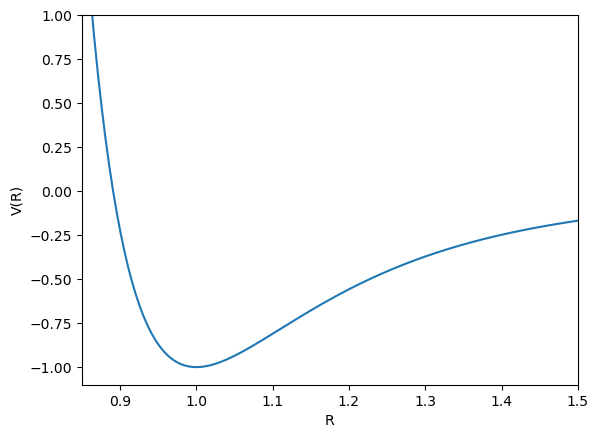

-0.677748041636447


In [110]:
def lj0(R,eps,r0):
    return eps*((r0/R)**12-2.0*(r0/R)**6)

R = np.linspace(0.5,3.0,500)
eps = 1.0
r0 = 1.0
plt.plot(R,lj0(R,eps,r0))
plt.xlabel('R')
plt.ylabel('V(R)')
plt.xlim((0.85,1.5))
plt.ylim((-1.1,1.0))
plt.show()

print(lj0(1.15,eps,r0))

The energy is at a minimum at a position defined by the value of $r_0$. At larger separations the potential is somewhat attractive, whereas at smaller separations the potential rapidly becomes strongly repulsive.

### Obtaining the force between two atoms
If the potential energy of a pair of atoms as a function of their separation, $V(R)$ is known, then the force acting between them, $F(R)$, can easily be obtained by differentiating the potential energy with respect to distance. Hence for the Lennard-Jones potential the force between two atoms is given by

$$
F(R) = -\frac{\textrm{d} V}{\textrm{d} R} =  \frac{12\epsilon}{r_0} \left[\left(\frac{r_0}{R}\right)^{7} - \left(\frac{r_0}{R}\right)^{13} \right].
$$

To define a function to give the value of this force:

In [26]:
def flj0(R,eps,r0):
    return 12*eps/r0*((r0/R)**7-(r0/R)**13)

#### Plot the Lennard-Jones force
Plot out the force for $0.95 \lt R \lt 1.5$, for the case $r_0=1.0$ and $\epsilon=1.0$. Look for the points at which $F=0$ and F is a maximum. What do these points correspond to in the plot of the Lennard-Jones potential energy above?

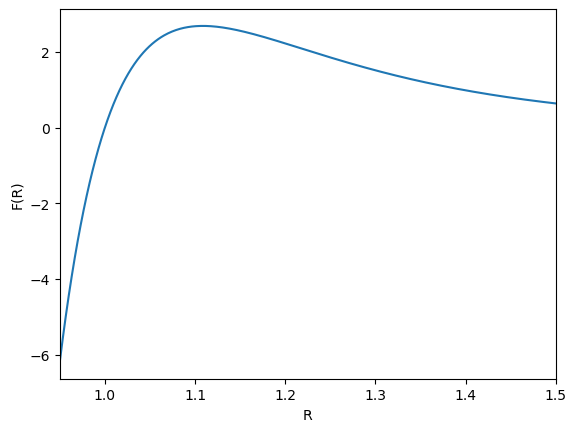

In [108]:
R = np.linspace(0.95,1.5,500)
eps = 1.0
r0 = 1.0
plt.plot(R,flj0(R,eps,r0))
plt.xlabel('R')
plt.ylabel('F(R)')
plt.xlim((0.95,1.5))
plt.show();
#plt.ylim((-1.0,3.0))

The force is zero where the potential energy is a minimum. The force will be a maximum at the point of inflection in the potential energy curve.

### Improving the efficiency 
The range of the Lennard-Jones potential is infinite, meaning that even pairs of atoms that are very far apart still contribute to the total potential energy of the system. However, the strength of the interaction decays rapidly with increasing separation, so there is little advantage in considering pairs of atoms more than a few lattice parameters apart. This fact is often exploited to improve simulation efficiency by assuming that atoms separated by a distance greater than some cut-off distance, denoted $r_{\textrm{cut}}$, have a negligible interaction. This approximation is physically valid for many real materials, such as metals, but may be less accurate when long-range forces, such as the Coulomb interaction, are significant.

Adjustments can be made to the potential as follows, labelling the new potential $V_{\textrm{cut}}(R)$:

$$
V_{\textrm{cut}}(R) = V(R) + \epsilon \alpha   \qquad r<=r_{\textrm{cut}},
$$

$$
V_{\textrm{cut}}(R) = 0 \qquad r>r_{\textrm{cut}},
$$

The term in $\alpha$ is a fixed energy shift of the potential at all values of $R$ below the cut-off. It is introduced in order to ensure that the potential goes to zero at the cut-off. The value of $\alpha$ will be given by:

$$
\alpha = -\frac{V(r_{\textrm{cut}})}{\epsilon}.
$$



### Implementing the cut-off

In [30]:
def lj(R,eps,r0,rcut,alpha):
    if R<=rcut:
        return eps*((r0/R)**12-2.0*(r0/R)**6)+alpha*eps
    else:
        return 0.0

Chose to cut off the potential at $r_{\mathrm{cut}}=1.5$ and calculate the shift parameter $\alpha$.

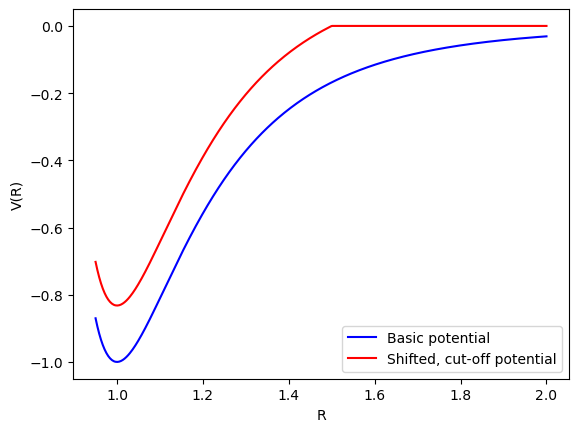

In [106]:
R = np.linspace(0.95,2.0,500)
eps = 1.0
r0 = 1.0
rcut = 1.5
alpha = -lj0(rcut,eps,r0)/eps

V = np.zeros(len(R))
for i in range(len(R)):
    V[i] = lj(R[i],eps,r0,rcut,alpha)
V0 = np.zeros(len(R))
for i in range(len(R)):
    V0[i] = lj0(R[i],eps,r0)

plt.plot(R,V0,'b',label='Basic potential')
plt.plot(R,V,'r',label='Shifted, cut-off potential')
plt.xlabel('R')
plt.ylabel('V(R)')
plt.legend()
plt.show();

This only gives a general idea of the potential. *Calibration* of the potential is required to choose values of the parameters that best represent the material to simulate.

### Calibrating the potential 1 - the length scale $r_0$
The Lennard-Jones potential contains only two adjustable parameters, so it cannot be expected to reproduce many of the more subtle features of a given material. However, it is possible to set $r_0$ to match the correct lattice parameter and $\epsilon$ to yield a reasonable binding energy. To do this, the potential energy contribution of a single atom in the perfect crystal is considered. This energy can be broken down into contributions from atoms in successive neighbor shells around the atom. For example, in a body-centered cubic (bcc) structure, each atom has 8 nearest neighbors at a separation of $\sqrt{3}a/2$, where $a$ is the cubic lattice parameter (half the length of the cube diagonal). The contribution from these atoms will be:

$$
U_{\textrm{atom}}^{\textrm{nn1}} = \frac{1}{2}8 V(\sqrt{3}a/2).
$$

The factor of $1/2$ accounts for the fact that each "bond" is shared between two atoms and the factor of 8 is because each atom has eight nearest neighbours. There are 6 second nearest neighbours, at a distance of $a$, giving a contribution to the energy of:

$$
U_{\textrm{atom}}^{\textrm{nn2}} = \frac{1}{2}6 V(a).
$$

There are then 12 third nearest neighbours at $\sqrt{2}a\approx 1.414 a$ giving a contribution of:

$$
U_{\textrm{atom}}^{\textrm{nn3}} = \frac{1}{2}12 V(\sqrt{2}a).
$$

and 24 fourth nearest neighbours at $\sqrt{11}/2 \,a \approx 1.658 a$. If the potential is truncated between the third and fourth nearest neighbors, for example by choosing $r_{\textrm{cut}}=1.5 a$, then the following holds:

$$
U_{\textrm{atom}} = U_{\textrm{atom}}^{\textrm{nn1}} + U_{\textrm{atom}}^{\textrm{nn2}} + U_{\textrm{atom}}^{\textrm{nn3}}
= 4V(\sqrt{3}a/2) + 3V(a) + 6 V(\sqrt{2}a).
$$

To determine the correct value of $r_0$, the energy per atom $U_{\textrm{atom}}$ is considered as a function of the lattice parameter $a$. If the crystal is isotropically compressed or expanded, this is expected to change the energy of the system. When the correct value for $r_0$ is chosen, the energy of the crystal will be minimized when the lattice parameter corresponds to the actual target value for the material being represented. This target value is denoted by $a^{\ast}$, and the condition can be expressed mathematically as:

$$
\frac{\mathrm{d}U_{\textrm{atom}}(a)}{\mathrm{d}a}\Bigg|_{a=a^{\ast}} = 0.
$$

Now, the expression for $U_{\textrm{atom}}$ could be differentiated with respect to $a$ analytically, and the equation could be solved by setting $a=a^{\ast}$. However, this approach involves considerable algebraic effort, so instead, Python will be used to find the optimal value for $r_0$.

In [34]:
# function to return energy per atom for given lattice parameter and potential specification
def Uatom0(a,eps,r0):
    return 4.0*lj0(np.sqrt(3.0)*a/2.0,eps,r0) + 3.0*lj0(a,eps,r0)  + 6.0*lj0(np.sqrt(2)*a,eps,r0)

# function to find the lattice parameter that minimises per atom energy for a given potential specification
def minUatom0(eps,r0):
    arange = np.linspace(1.0,3.5,400)
    amin = 0.0
    minu = 999999.0
    for a in arange:
        # print(a,Uatom(a,eps,r0))
        if Uatom0(a,eps,r0) < minu:
            minu = Uatom0(a,eps,r0) 
            amin = a
    return amin

targeta = 2.86 # value of the lattice parmeter targeted to achieve
eps = 1.0
r0range = np.linspace(2.0,3.0,400) # range of values for r0 to explore
r0best = 0.0 # current best guess for r0
besterror = 999.9 # Eeror in value of a for current best r0
amins = [] # list of a values 

# exploring a range of values for r0 and calculating the equilibrium lattice parameter for each
# record value, if this value is closer to target value than previous results, store
for r0 in r0range:
    amin = minUatom0(eps,r0)
    amins.append(amin)
    if abs(targeta - amin) < besterror:
        besterror = abs(targeta - amin)
        r0best = r0

abest = minUatom0(eps,r0best)

# report and plot results
plt.plot(r0range,amins,'b-',label='Optimal $a$')
plt.plot(r0best,abest,'ro',label='Target $a$')
plt.xlabel('$r_0$')
plt.ylabel('$a$')
print('Best value of r0 is ' + str(r0best) + ', giving a lattice parameter of ' + str(abest))
print('This assumes a cut-off, rcut ' + str(1.5*abest))

Best value of r0 is 2.56140350877193, giving a lattice parameter of 2.8609022556390977
This assumes a cut-off, rcut 4.291353383458647


### Calibrating the potential 2 - the potential shift, $\alpha$
When the potential is truncated at $r_{\mathrm{cut}}$, it is necessary to shift it in energy by an amount $\alpha\epsilon$ to ensure that the potential is zero at the cutoff. The equation for $\alpha$ is given above. It is:

$$
\alpha = -\frac{V(r_{\textrm{cut}})}{\epsilon}.
$$

The situation is slightly complicated by the fact that the value of $\epsilon$, which sets the energy scale of the potential, is not yet known. However, the value of $\alpha$ can be determined by assuming $\epsilon = 1.0$.

In [36]:
eps = 1.0
r0 = 2.5614
rcut = 4.2914

print('alpha = ' + str(-1.0*lj0(rcut,eps,r0)))

alpha = 0.08838320116205785


### Calibrating the potential 3 - the energy scale, $\epsilon$
One way to set the energy scale of the potential, controlled by the parameter $\epsilon$, is to calibrate it against the cohesive energy of the material being studied. The cohesive energy is defined as the difference in the energy per atom between the bonded state and the completely dissociated state. In this case, it is given by the difference in $U_{\mathrm{atom}}$ between a lattice with the optimized lattice parameter and one where the atoms are infinitely far apart. Since the parameter $\epsilon$ scales the energy of all interactions uniformly, the required value can be obtained by taking the ratio of the target cohesive energy to the negative of the energy of an atom at the equilibrium lattice parameter.

In [ ]:
# defining a new function to return the energy per atom for the potential with a cut-off and a shift

In [38]:
# function to return energy per atom for given lattice parameter and potential specification for the shifted, cut-off potential
def Uatom(a,eps,r0,rcut,alpha):
    return 4.0*lj(np.sqrt(3.0)*a/2.0,eps,r0,rcut,alpha) + 3.0*lj(a,eps,r0,rcut,alpha)  + 6.0*lj(np.sqrt(2)*a,eps,r0,rcut,alpha)

In [ ]:
# assuming target value of 4.28 for the cohesive energy

In [40]:
alatt = 2.86
eps = 1.0
r0 = 2.5614
rcut = 4.2914
alpha = 0.0884

Ucoh = 4.28

print('Energy per atom with eps=1.0 is ' + str(Uatom(alatt,eps,r0,rcut,alpha)))
print('So, required eps is ' + str(-Ucoh/Uatom(alatt,eps,r0,rcut,alpha)))


Energy per atom with eps=1.0 is -5.697957898183445
So, required eps is 0.751146301267775


### The final parameterisation:
All parameters for the shifted Lennard-Jones potential, with a cutoff between the third and fourth nearest neighbors, have now been determined to correctly reproduce the equilibrium lattice parameter and cohesive energy of bcc iron.

In [42]:
alatt = 2.86
eps = 0.7511
r0 = 2.5614
rcut = 4.2914
alpha = 0.0884

In [ ]:
# code below shows shifted form of the potential.

In [44]:
R = np.linspace(2.0,5.0,500)
V = np.zeros(len(R))
for i in range(len(R)):
    V[i] = lj(R[i],eps,r0,rcut,alpha)

nn = np.array([   
    [np.sqrt(3.0)*alatt/2.0,lj(np.sqrt(3.0)*alatt/2.0,eps,r0,rcut,alpha)],
    [alatt,lj(alatt,eps,r0,rcut,alpha)],
    [np.sqrt(2)*alatt,lj(np.sqrt(2)*alatt,eps,r0,rcut,alpha)],
    [np.sqrt(11)*alatt/2.0,lj(np.sqrt(11)*alatt/2.0,eps,r0,rcut,alpha)]
])
plt.axhline(y=0.0)
plt.axvline(x=r0)
plt.axvline(x=rcut)
plt.plot(R,V,'r',label='Shifted, cut-off potential')
plt.plot(nn[:,0],nn[:,1],'bo',label='Nearest neighbour separations and energies')
plt.xlabel('R')
plt.ylabel('V(R)')
plt.legend()
plt.ylim(-1.0,0.5)



(-1.0, 0.5)

### The Lennard-Jones force with the shifted potential

In [ ]:
# defining a function to return the force due to the truncated, shifted potential

In [46]:
 def flj(R,eps,r0,rcut,alpha):
    if R<=rcut:
        return 12*eps/r0*((r0/R)**7-(r0/R)**13)
    else:
        return 0.0

#### Plot the Lennard-Jones force for the truncated shifted form


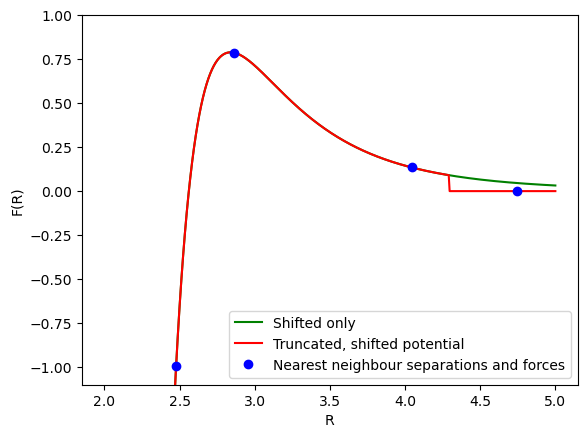

In [70]:
alatt = 2.86
eps = 0.7511
r0 = 2.5614
rcut = 4.2914
alpha = 0.0884

R = R = np.linspace(2.0,5.0,500)

f = np.zeros(len(R))
for i in range(len(R)):
    f[i] = flj(R[i],eps,r0,rcut,alpha)
ffull = np.zeros(len(R))
for i in range(len(R)):
    ffull[i] = flj(R[i],eps,r0,100.0,alpha)
    
nn = np.array([   
    [np.sqrt(3.0)*alatt/2.0,flj(np.sqrt(3.0)*alatt/2.0,eps,r0,rcut,alpha)],
    [alatt,flj(alatt,eps,r0,rcut,alpha)],
    [np.sqrt(2)*alatt,flj(np.sqrt(2)*alatt,eps,r0,rcut,alpha)],
    [np.sqrt(11)*alatt/2.0,flj(np.sqrt(11)*alatt/2.0,eps,r0,rcut,alpha)]
])
plt.plot(R,ffull,'g', label='Shifted only')
plt.plot(R,f,'r', label='Truncated, shifted potential')
plt.plot(nn[:,0],nn[:,1],'bo',label='Nearest neighbour separations and forces')
plt.xlabel('R')
plt.ylabel('F(R)')
plt.ylim((-1.1,1.0))
plt.legend()
plt.show();    


## Periodic boundary conditions
When simulating materials at the atomistic scale, the goal is often to replicate the behavior of a much larger sample using a small number of atoms. This approach is typically due to computational limitations that only allow the simulation of a small number of atoms. However, care must be taken, as there is a risk that the behavior of the bulk material may not be accurately captured.

For example, consider a simulation of a box containing 1000 atoms in a simple cubic lattice. This corresponds to a $10\times 10\times10$ unit cell box, meaning that approximately half of the atoms will be near the surface of the simulated material. Surface effects could significantly influence the behavior of the simulation, potentially leading to spurious results.

A common solution to this issue is the use of *periodic boundary conditions*. These conditions cause the system to 'wrap around' at the edges of the box, effectively creating an infinite array of identical copies of the simulation cell. This means that an atom on the far left of the box will interact with an atom on the far right, and any atom moving out of the box on one side will reappear on the opposite side.

To implement this correctly, periodic boundaries must be accounted for in the simulation algorithm.

## Calculating the forces on the atoms
Arrays have been set up to record the state of the system of atoms, and functions have been developed to calculate the potential energy and the forces acting on each atom. The next step is to determine how the state of the system will evolve. To do this, the forces acting on all the atoms and the resulting accelerations must be known.

In [ ]:
# defining a function to work out the acceleration of each atom
# including logic to deal with periodic boundary conditions

In [54]:
def calcaccln(a,r,m):
    mconv = 1.036e-4
    for i in range(len(r)):
        a[i,:] = 0.0
    for i in range(len(r)):
        for j in range(i):
            disp = (r[j,:]-r[i,:]) # calculating displacement between atoms
            for s in range(3): # checking if atoms are closer across periodic boundaries than within the box in each dimension
                if disp[s] > 0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] - boxsize[s]*cell[s,s] # adjusting displacement for periodic boundary
                elif disp[s] < -0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] + boxsize[s]*cell[s,s] # adjusting displacement for periodic boundary    
            R = np.linalg.norm(disp)
            a[i,:] = a[i,:] + flj(R,eps,r0,rcut,alpha)*disp[:]/R/m[i]/mconv
            a[j,:] = a[j,:] - flj(R,eps,r0,rcut,alpha)*disp[:]/R/m[j]/mconv
    return R

## Evolving the state of the system
The next task is to develop code that calculates the positions and velocities of all the particles at a time $t+\delta t$, given their positions and velocities at time $t$, where $\delta t$ is the time step. There are various algorithms for this, with the velocity-Verlet algorithm being one of the most commonly used. This algorithm, which was discussed in the lectures, can be written as follows:

$$
v(t+ \frac{1}{2}t) = v(t) + \frac{1}{2}a(t)\delta t,
$$

$$
r(t+\delta t) = v(t+ \frac{1}{2}\delta t)\delta t,
$$

$$
v(t+\delta t) = v(t+ \frac{1}{2}\delta t) + \frac{1}{2}a(t+\delta t)\delta t.
$$


In [ ]:
# defining a function to implement the above evolution

In [56]:
def vv(r,v,a,m,dt):
    v += 0.5*a*dt
    r += v*dt
    calcaccln(a,r,m)
    v += 0.5*a*dt
    for s in range(3):
        for i in range(len(r)):
            if r[i,s] > boxsize[s]*cell[s,s]:
                r[i,s] = r[i,s] - boxsize[s]*cell[s,s]
            elif r[i,s] < 0.0:
                r[i,s] = r[i,s] + boxsize[s]*cell[s,s]
    return    

### Some useful output 
A major part of the work involved in research using atomistic simulation is in interpreting the data. Widely used MD codes tend to have lots of functionality for producing useful output based on the raw data for the positions and velocities of the atoms.

In [ ]:
# defining functions to return the total potential and kinetic energy of our system of atoms

In [58]:
def pe(r):
    pe = 0.0
    for i in range(len(r)):
        for j in range(i):
            disp = np.abs(r[j,:]-r[i,:]) # calculating displacement between atoms
            for s in range(3): # checking if atoms are closer across periodic boundaries in each dimension
                if disp[s] > 0.5*boxsize[s]*cell[s,s]:
                    disp[s] = disp[s] - boxsize[s]*cell[s,s] # adjusting displacement for periodic boundary  
            R = np.linalg.norm(disp)
            pe = pe + lj(R,eps,r0,rcut,alpha)
    return pe

def ke(v,m):
    mconv = 1.036e-4
    ke = 0.0
    for i in range(len(r)):
        ke = ke + m[i]*(v[i,0]*v[i,0] + v[i,1]*v[i,1] + v[i,2]*v[i,2])
    return 0.5*mconv*ke

## Running a simulation

In [ ]:
# defining functions to run an MD simulation

In [60]:
def run(r,v,a,m,dt,nsteps):
    # lists to record the history of the first two atoms in the atom arrays
    R0 = [r[0,:].tolist()]
    R1 = [r[1,:].tolist()]
    V0 = [v[0,:].tolist()]
    V1 = [v[1,:].tolist()]
    A0 = [a[0,:].tolist()]
    A1 = [a[1,:].tolist()]
    # lists to record the history of the total potential and kinetic energy of the system of atoms
    pelog = [pe(r)]
    kelog = [ke(v,m)]
    print('Running simulation of ' + str(nsteps) + ' steps')
    print('Progress:')
    for t in range(nsteps):
        # printing a progress indication
        if (t+1)%10 == 0:
            print(str(t+1) + '.', end='')
        # evolving for one time step
        vv(r,v,a,m,dt)
        # adding current values to lists recording histories
        R0.append(r[0,:].tolist())
        R1.append(r[1,:].tolist())
        V0.append(v[0,:].tolist())
        V1.append(v[1,:].tolist())
        A0.append(a[0,:].tolist())
        A1.append(a[1,:].tolist())
        pelog.append(pe(r))
        kelog.append(ke(v,m))
        if (t+1)%100 == 0:
            print('')
    print()
    return np.array(R0),np.array(R1),np.array(V0),np.array(V1),np.array(A0),np.array(A1),np.array(pelog),np.array(kelog)

### A small collision cascade 
The simulation involves a box containing $4\times 4\times 4$ unit cells of body-centered cubic (bcc) Fe, with an atomic mass of 55.8 atomic mass units and a lattice parameter of 2.86 angstroms. The shifted, truncated Lennard-Jones potential, which was parameterized earlier, is used. The timestep is set to 0.0001 ps (0.1 fs), and atom 0 is assigned an initial velocity of (600,500,700) ang per ps. The simulation runs for 400 timesteps (40 fs).

In [62]:
L = 4 # length of cube sides in unit cells
boxsize = np.array([L,L,L]) # defining a cubic box in multiples of the unit cell size in each direction

alatt = 2.86 # lattice parameter
cell = np.array([
        [alatt,0,0],
        [0,alatt,0],
        [0,0,alatt]
    ]) # specifying vectors in rows of an array
motif = np.array([
        [0.0,0.0,0.0],
        [0.5,0.5,0.5] # positions of atoms in motif in multiples of lattice vectors
    ])
nmotif = len(motif) # number of atoms in motif

r = createcrystal(cell,motif,nmotif,boxsize)
# plotcell(r)

natoms = len(r) # obtaining total number of atoms

mass = 55.8
m = np.full(natoms,mass)
v = np.zeros((natoms,3))
a = np.zeros((natoms,3))

alatt = 2.86
eps = 0.7511
r0 = 2.5614
rcut = 4.2914
alpha = 0.0884

dt = 0.0001
vpka = [600.0,500.0,700.0]
v[0,:] = vpka

R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,400)



Running simulation of 400 steps
Progress:
10.20.30.40.50.60.70.80.90.100.
110.120.130.140.150.160.170.180.190.200.
210.220.230.240.250.260.270.280.290.300.
310.320.330.340.350.360.370.380.390.400.



In [ ]:
# plotting the kinetic and potential energy during the simulation

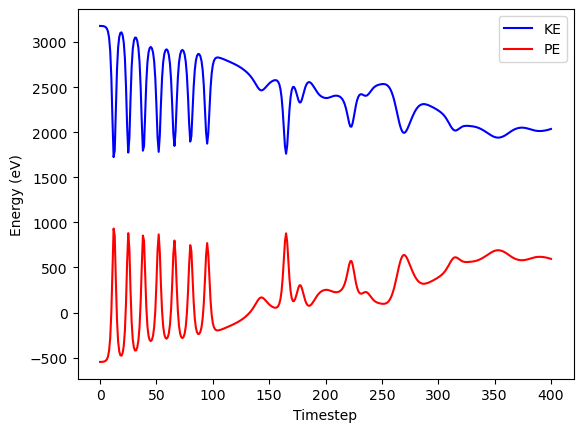

In [68]:
plt.plot(kelog[:], 'b-', label='KE')
plt.plot(1.0*(pelog[:]), 'r-', label='PE')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Energy (eV)')
plt.show();

The plot shows that the initial velocity of atom 0 results in an initial kinetic energy of approximately 3 keV, which is sufficient to induce damage to the crystal structure. The kinetic energy oscillates up and down, and as it does so, the potential energy fluctuates in the opposite direction.

Atoms are colliding with one another. As an atom approaches a collision, it slows down due to the repulsive interaction with the target atom. This causes a decrease in its kinetic energy, while the potential energy increases. During the latter part of the collision, the target atom is accelerated away with increasing kinetic energy, and the potential energy decreases. These oscillations in energy reflect the collisions occurring between atoms.

### Conservation of energy
As noted earlier, the potential energy varies in the opposite direction to the kinetic energy. Is it possible to quantify this relationship? Since the system is *closed,* meaning no energy is allowed to enter or leave, energy should be strictly conserved. Therefore, the sum of the kinetic and potential energy should remain constant throughout the simulation.

#### Plot a graph of energy conservation

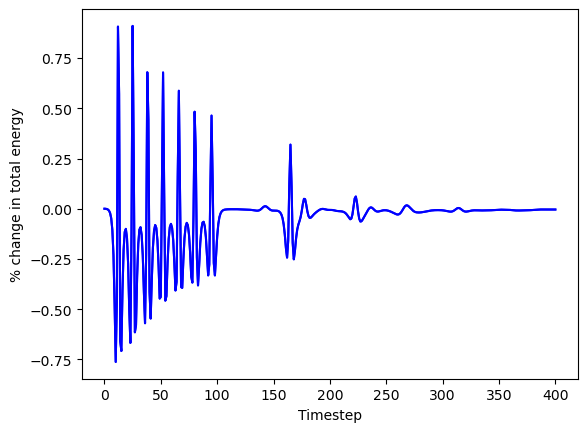

In [75]:
plt.plot(100.0*(kelog[:]+pelog[:]-kelog[0]-pelog[0])/(kelog[0]+pelog[0]),'b-')
plt.xlabel('Timestep')
plt.ylabel('% change in total energy')
plt.show();

The plot above shows the conservation of energy with the % change of the total energy from the initial value. During collisions there is up to a 0.75% spurious gain or loss of energy, although this is reversed following a collision. Overall, energy seems to be well conserved.

### Visualising the damage

#### Visualise the final atomic configuration using `plotcell()`

In [82]:
plotcell(r,cell,boxsize);

In [ ]:
# an alternative way of looking at the data produced above:

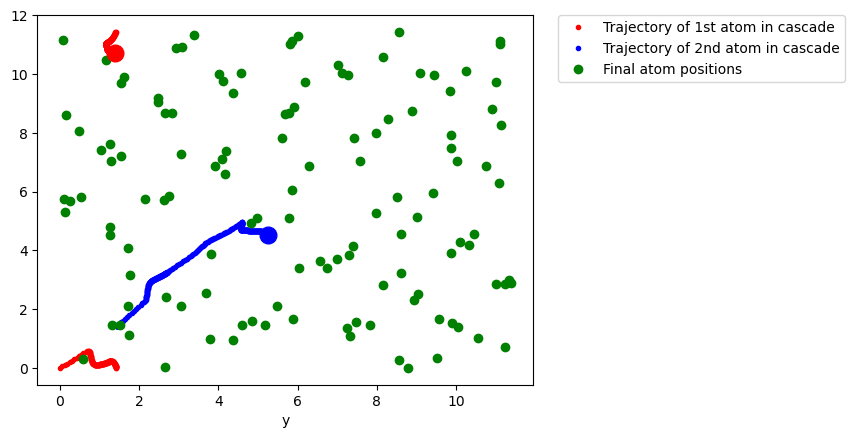

In [86]:
plt.plot(R0[:,0],R0[:,1], 'r.', label='Trajectory of 1st atom in cascade')
plt.plot(R1[:,0],R1[:,1], 'b.', label='Trajectory of 2nd atom in cascade')
plt.plot(r[:,0],r[:,1],'go', label='Final atom positions')
plt.plot(R0[-1,0],R0[-1,1], marker="o", color='red', markersize=12)
plt.plot(R1[-1,0],R1[-1,1], marker="o", color='blue', markersize=12)
plt.xlabel('x')
plt.xlabel('y')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
plt.show();

## A binary collision of one moving atom with a stationary one

In [88]:
L = 4 # length of cube sides in unit cells
boxsize = np.array([2*L,L,L]) # defining a cubic box in multiples of the unit cell size in each direction

alatt = 2.86 # lattice parameter
cell = np.array([
        [alatt,0,0],
        [0,alatt,0],
        [0,0,alatt]
    ]) # specifying vectors in rows of an array
motif = np.array([
        [0.0,0.0,0.0],
        [0.5,0.5,0.5] # postions of atoms in motif in multiples of lattice vectors
    ])
nmotif = len(motif) # number of atoms in motif

r = np.array([[alatt,L/2.0*alatt,L/2.0*alatt],[alatt+3.0,L/2.0*alatt,L/2.0*alatt]])

natoms = len(r) # obtaining total number of atoms
mass = 55.8
m = np.full(natoms,mass)
v = np.zeros((natoms,3))
a = np.zeros((natoms,3))

eps = 0.7511
r0 = 2.5614
rcut = 4.2914
alpha = 0.0884

#### 1.9.0.1. Visualise the initial simulation cell configuration

In [90]:
plotcell(r,cell,boxsize)

In [ ]:
# giving a kick to one of the atoms and running a simulation

In [92]:
dt = 0.0001
vpka = [50.0,5.0,5.0]
v[0,:] = vpka
R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,2000)

Running simulation of 2000 steps
Progress:
10.20.30.40.50.60.70.80.90.100.
110.120.130.140.150.160.170.180.190.200.
210.220.230.240.250.260.270.280.290.300.
310.320.330.340.350.360.370.380.390.400.
410.420.430.440.450.460.470.480.490.500.
510.520.530.540.550.560.570.580.590.600.
610.620.630.640.650.660.670.680.690.700.
710.720.730.740.750.760.770.780.790.800.
810.820.830.840.850.860.870.880.890.900.
910.920.930.940.950.960.970.980.990.1000.
1010.1020.1030.1040.1050.1060.1070.1080.1090.1100.
1110.1120.1130.1140.1150.1160.1170.1180.1190.1200.
1210.1220.1230.1240.1250.1260.1270.1280.1290.1300.
1310.1320.1330.1340.1350.1360.1370.1380.1390.1400.
1410.1420.1430.1440.1450.1460.1470.1480.1490.1500.
1510.1520.1530.1540.1550.1560.1570.1580.1590.1600.
1610.1620.1630.1640.1650.1660.1670.1680.1690.1700.
1710.1720.1730.1740.1750.1760.1770.1780.1790.1800.
1810.1820.1830.1840.1850.1860.1870.1880.1890.1900.
1910.1920.1930.1940.1950.1960.1970.1980.1990.2000.



The trajectories of the two colliding atoms can be observed and the output of `run()` can be interrogated to find out various things about the collision outcome. For example:

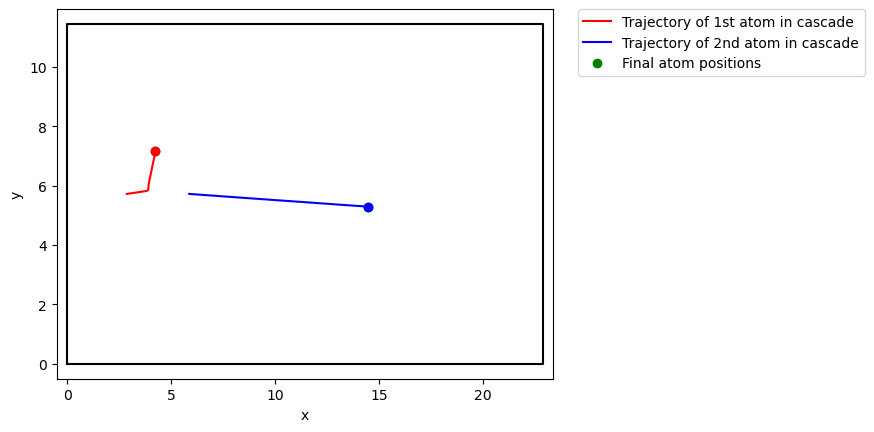

In [98]:
plt.plot(R0[:,0],R0[:,1], 'r-', label='Trajectory of 1st atom in cascade')
plt.plot(R1[:,0],R1[:,1], 'b-', label='Trajectory of 2nd atom in cascade')
plt.plot(r[:,0],r[:,1],'go', label='Final atom positions')
plt.plot(R0[-1,0],R0[-1,1], 'ro')
plt.plot(R1[-1,0],R1[-1,1], 'bo')
cellbox = np.array([  [0.0,0.0],  [0.0,cell[1,1]*boxsize[1]],   [cell[0,0]*boxsize[0],cell[1,1]*boxsize[1]],   [cell[0,0]*boxsize[0],0.0],  [0.0,0.0]  ])
plt.plot(cellbox[:,0],cellbox[:,1],'k-')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.5,cell[0,0]*boxsize[0]+0.5)
plt.ylim(-0.5,cell[1,1]*boxsize[1]+0.5)
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
plt.show();


In [100]:
print('Final velocity of projectile atom: [%6.2f,%6.2f,%6.2f]' % (V0[-1,0],V0[-1,1],V0[-1,2]) )
print('Final velocity of target atom: [%6.2f,%6.2f,%6.2f]' % (V1[-1,0],V1[-1,1],V1[-1,2]) )

Final velocity of projectile atom: [  2.20,  7.37,  7.37]
Final velocity of target atom: [ 47.80, -2.37, -2.37]


### Running a set of simulations (with varying input parameters)

In [ ]:
# using a for loop to run a simulation of a binary collision with different values for the projectile velocity
# recording the final velocity of the target atom in each case

Running simulation of 2000 steps
Progress:
10.20.30.40.50.60.70.80.90.100.
110.120.130.140.150.160.170.180.190.200.
210.220.230.240.250.260.270.280.290.300.
310.320.330.340.350.360.370.380.390.400.
410.420.430.440.450.460.470.480.490.500.
510.520.530.540.550.560.570.580.590.600.
610.620.630.640.650.660.670.680.690.700.
710.720.730.740.750.760.770.780.790.800.
810.820.830.840.850.860.870.880.890.900.
910.920.930.940.950.960.970.980.990.1000.
1010.1020.1030.1040.1050.1060.1070.1080.1090.1100.
1110.1120.1130.1140.1150.1160.1170.1180.1190.1200.
1210.1220.1230.1240.1250.1260.1270.1280.1290.1300.
1310.1320.1330.1340.1350.1360.1370.1380.1390.1400.
1410.1420.1430.1440.1450.1460.1470.1480.1490.1500.
1510.1520.1530.1540.1550.1560.1570.1580.1590.1600.
1610.1620.1630.1640.1650.1660.1670.1680.1690.1700.
1710.1720.1730.1740.1750.1760.1770.1780.1790.1800.
1810.1820.1830.1840.1850.1860.1870.1880.1890.1900.
1910.1920.1930.1940.1950.1960.1970.1980.1990.2000.

Running simulation of 2000 steps
Progress:
1

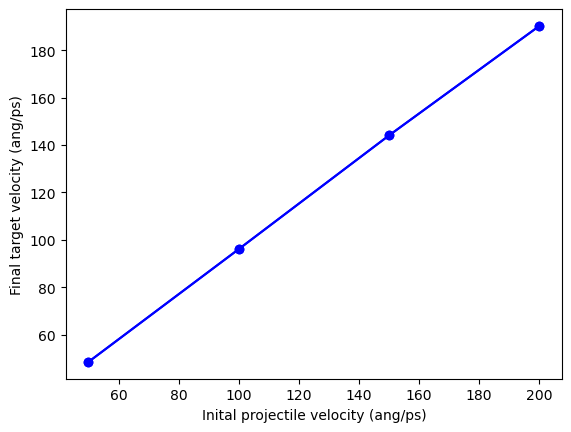

In [104]:
initv = [50.0, 100.0, 150.0, 200.0]
finalv = []
dt = 0.0001
for i in range(4):
    r = np.array([[2.0,5.5,5.0],[7.0,5.0,5.0]])
    natoms = len(r)
    mass = 55.8
    m = np.full(natoms,mass)
    v = np.zeros((natoms,3))
    a = np.zeros((natoms,3)) 
    vpka = [initv[i],0.0,0.0]
    v[0,:] = vpka
    R0,R1,V0,V1,A0,A1,pelog,kelog = run(r,v,a,m,dt,2000)
    finalv.append(np.linalg.norm(V1[-1,:]))

plt.plot(np.array(initv),np.array(finalv),'bo-')
plt.xlabel('Inital projectile velocity (ang/ps)')
plt.ylabel('Final target velocity (ang/ps)')
plt.show();

In [ ]:
# end of coursework